In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
    except RuntimeError as e:
        print(e)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from PIL import Image, ImageEnhance

In [3]:
# create rle for dataset_1
%run etc/create_rle_for_dataset_1.ipynb

In [4]:
# crop the image into patches of 256x256  and save them
%run etc/crop_image_save.ipynb

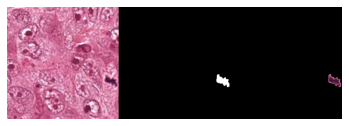

In [5]:
#import data 
%run etc/import_data_256.ipynb

In [6]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

def unet(sz = (256,256, 3)):
    x = Input(sz)
    inputs = x
  
  #down sampling 
    f = 8
    layers = []

    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)        
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2
    ff2 = 64 
  
  #bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
  
  #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 
    
  
  #classification 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [7]:
model=unet()

In [8]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
history=model.fit(train_generator, 
                    epochs = 50, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps, verbose = 1)


Epoch 1/50
443/443 [==============================] - 20s 45ms/step - loss: 0.1222 - accuracy: 0.9902 - val_loss: 0.0528 - val_accuracy: 0.9910
Epoch 2/50
443/443 [==============================] - 19s 44ms/step - loss: 0.0495 - accuracy: 0.9906 - val_loss: 0.0569 - val_accuracy: 0.9897
Epoch 3/50
443/443 [==============================] - 19s 44ms/step - loss: 0.0507 - accuracy: 0.9900 - val_loss: 0.0625 - val_accuracy: 0.9886
Epoch 4/50
443/443 [==============================] - 19s 44ms/step - loss: 0.0468 - accuracy: 0.9907 - val_loss: 0.0617 - val_accuracy: 0.9892
Epoch 5/50
443/443 [==============================] - 19s 44ms/step - loss: 0.0485 - accuracy: 0.9903 - val_loss: 0.0520 - val_accuracy: 0.9906
Epoch 6/50
443/443 [==============================] - 19s 44ms/step - loss: 0.0456 - accuracy: 0.9910 - val_loss: 0.0406 - val_accuracy: 0.9933
Epoch 7/50
443/443 [==============================] - 20s 44ms/step - loss: 0.0483 - accuracy: 0.9901 - val_loss: 0.0540 - val_accuracy:

In [ ]:
#loading dataset_2

In [25]:
import tifffile

In [26]:
for im in os.listdir('dataset_2/'):
    t=tifffile.imread(f'dataset_2/{im}')
    i=Image.fromarray(t)
    i=i.resize((1536,1280))
    i=np.array(i)
    #crop the dataset2 image into patches of 256x256  and save them
    x=0
    xplus=256
    y=0
    yplus=256
    file_name=0
    for q in range(6):
        for s in range(5):
            tempy=i[x:xplus,y:yplus]
            plt.imsave(f'temp/{str(q)+str(s)}.bmp',tempy)


            file_name+=1
            x+=256
            xplus+=256

        x=0
        xplus=256
        y+=256
        yplus+=256
    all_files = os.listdir('temp/')
    all_files.sort()
    temparray=np.zeros((1280, 1536, 3),dtype=np.uint8)

    #merging rle into one image and saving it into rle_image_dataset_2 folder

    x=0
    xplus=256
    y=0
    yplus=256
    file_name=0
    for q in range(6):
        for s in range(5):

            ttt=plt.imread(f'temp_result/{str(q)+str(s)}.bmp')
            temparray[x:xplus,y:yplus]=ttt
            x+=256
            xplus+=256
        x=0
        xplus=256
        y+=256
        yplus+=256
    plt.imsave(f'rle_image_dataset_2/{im[:-5]}.png',temparray)

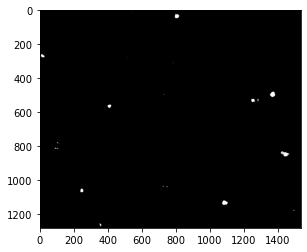

In [20]:
plt.imshow(temparray)